#### Residual Neural Network

In [ ]:
from tensorflow.keras.models import load_model

import h5py   # HDF5 data file management library
import pandas as pd

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, ReLU
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Add, BatchNormalization, Concatenate, AveragePooling2D, LeakyReLU, Lambda
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
inc = 0

import keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('gdrive', force_remount=True)

Mounted at gdrive


In [ ]:
cd gdrive/My Drive/Colab Notebooks/.../

#### Load and prepare the dataset

In [ ]:
# Data loading
data_psi = pd.read_csv("Dataset_torque.csv",header=None,dtype='float32')
data_Mat = pd.read_csv("Dataset_image.csv",header=None,dtype='float32')


data_psi = data_psi.values;
data_Mat = data_Mat.values;

# Normalization
data_psi = -np.log10(np.abs(data_psi)) 
data_psi = (data_psi - min(data_psi))/(max(data_psi)-min(data_psi))*10


In [ ]:
print(data_psi.shape)
print(data_Mat.shape)

(8901, 1)
(1139328, 128)


In [ ]:
# Reshape data
data_psi = np.reshape(data_psi,[len(data_psi),1])
s_mat = data_Mat.shape[1]
print(len(data_Mat)/s_mat)
data_Mat = data_Mat.reshape(int(data_Mat.shape[0]/s_mat), s_mat, s_mat, 1) 
print(len(data_psi))

8901.0
8901


[4.010752]


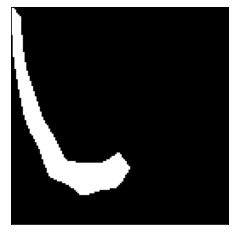

In [ ]:
pos =0;
plt.imshow(data_Mat[pos, :, :, 0], 'gray')
plt.xticks([])
plt.yticks([])
print(data_psi[pos])


In [ ]:
#shuffling and dividing the data
batch_size = 10
nb_train = np.floor(.9*len(data_Mat)/batch_size)*batch_size
nb_batch = nb_train/batch_size

indices = np.arange(data_Mat.shape[0])
np.random.shuffle(indices)

data_Mat = data_Mat[indices]
data_psi =data_psi[indices]

xtrain, xtest = np.split(
    data_Mat, 
    [ int(nb_train)
    ]
)

ytrain, ytest = np.split(
    data_psi, 
    [int(nb_train)
    ]
)

del data_Mat
del data_psi

In [ ]:
ytrain.shape


(8010, 1)

#### Define the loss and optimizers



In [ ]:
lr = 2e-4
optimizer_type = Adam()  
loss = 'mean_squared_error'
metrics = ['mean_squared_error']  
dropout_ratio = 0.3  
validtrain_split_ratio = 0.2  
max_epochs = 40 
batch_shuffle = True   
num_hidden = 30; 

#### Define the blocks

In [ ]:
def block(input_tensor,nb_filters,kernel_sh,stride_s):
  x = Conv2D(filters=nb_filters,kernel_size=kernel_sh,padding="same",strides = stride_s)(input_tensor)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)
  return x

def resblock(input_tens,nb_filters,kernel_sh,stride_s):
    x = block(input_tens,nb_filters,kernel_sh,stride_s)
    x = block(x,nb_filters,kernel_sh,1)
    return x



#### Build blocks

In [ ]:
input_shape = (s_mat, s_mat, 1);
inputs1 = Input(shape=input_shape)

conv1l = block(inputs1,64,48,1)
resblock1 = resblock(conv1l,64,48,1)

add1 = Add()([resblock1,conv1l])
resblock1b = resblock(add1,64,48,1)

add1b = Add()([resblock1b,add1])
resblock2 = resblock(add1b,64,48,2)

conv2l = Conv2D(filters=64,kernel_size=1,padding="same",strides = 2)(add1b)

add2 = Add()([resblock2,conv2l])
resblock2b = resblock(add2,64,48,1)

add2b = Add()([resblock2b,add2])
resblock3 = resblock(add2b,64,48,2)

conv3l = Conv2D(filters=64,kernel_size=1,padding="same",strides = 2)(add2b)

add3 = Add()([resblock3,conv3l])
resblock3b = resblock(add3,64,24,1)

add3b = Add()([resblock3b,add3])
resblock4 = resblock(add3b,64,24,2)


flattenl = Flatten()(add3b)
dense_01l = Dense(num_hidden,kernel_regularizer = regularizers.l2(0.01))(flattenl)
dense_01l = LeakyReLU()(dense_01l)

dense_02l = Dense(num_hidden,kernel_regularizer = regularizers.l2(0.01))(dense_01l)
dense_02l = LeakyReLU()(dense_02l)

outputs1 = Dense(ytrain.shape[1])(dense_02l)

##### Block structure

In [ ]:
print()
print('* Compiling the network model *')
print()

model = Model(inputs=inputs1, outputs=outputs1)
model.compile(optimizer=optimizer_type, loss=loss, metrics=metrics)

print(model.summary())  
print()


* Compiling the network model *

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  147520      ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                           

Graphical schematic of the compiled network



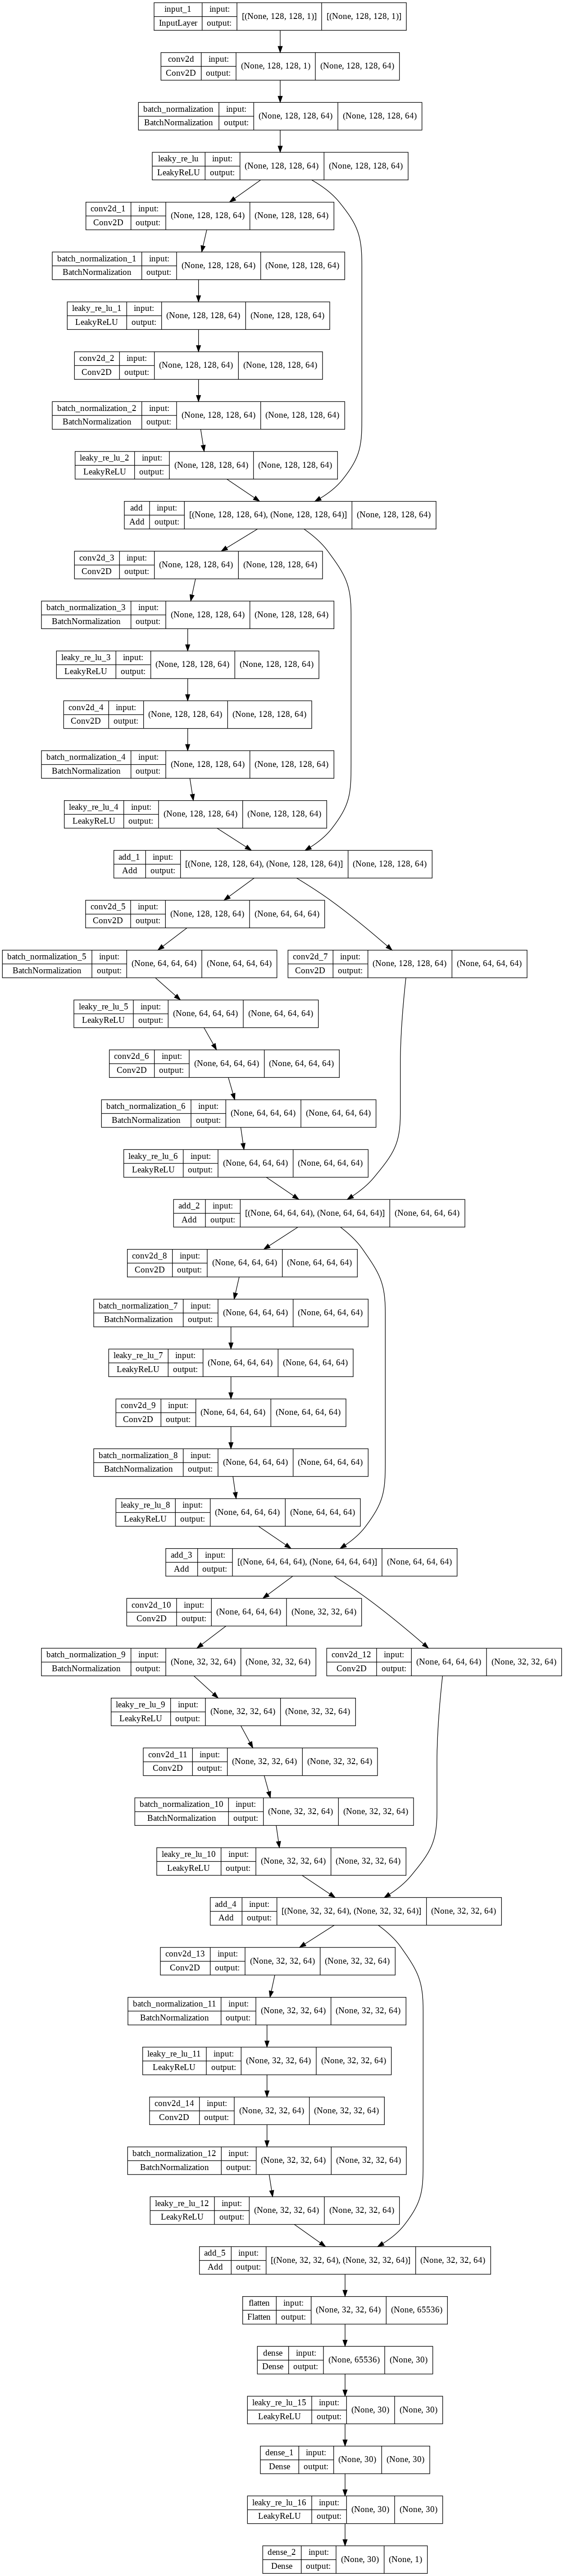

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

print('Graphical schematic of the compiled network')
print()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(filename='model.png')

#### Train the model

In [ ]:
inc = inc+1;

def schedule(epoch):
  return lr * (0.85 ** np.floor(epoch/6))

es = callbacks.LearningRateScheduler(schedule, verbose=1)
es2 = callbacks.EarlyStopping(monitor='val_mean_squared_error', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
es3 = callbacks.ModelCheckpoint('model2p64_conv.h5', monitor='val_mean_squared_error', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

history = model.fit(xtrain,ytrain, validation_split=0.1,
          batch_size=batch_size,
          epochs=max_epochs,
          verbose=1,
          callbacks=[es,es2,es3])

history_t = history



Epoch 1: LearningRateScheduler setting learning rate to 0.0002.
Epoch 1/40
721/721 [==============================] - ETA: 0s - loss: 10.8119 - mean_squared_error: 9.8861
Epoch 1: val_mean_squared_error improved from inf to 0.77034, saving model to model2p64_conv.h5
721/721 [==============================] - 919s 1s/step - loss: 10.8119 - mean_squared_error: 9.8861 - val_loss: 1.6911 - val_mean_squared_error: 0.7703 - lr: 2.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0002.
Epoch 2/40
721/721 [==============================] - ETA: 0s - loss: 1.7064 - mean_squared_error: 0.7935
Epoch 2: val_mean_squared_error improved from 0.77034 to 0.50148, saving model to model2p64_conv.h5
721/721 [==============================] - 864s 1s/step - loss: 1.7064 - mean_squared_error: 0.7935 - val_loss: 1.4054 - val_mean_squared_error: 0.5015 - lr: 2.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0002.
Epoch 3/40
721/721 [==============================] - ETA

#### Mean Squared Error

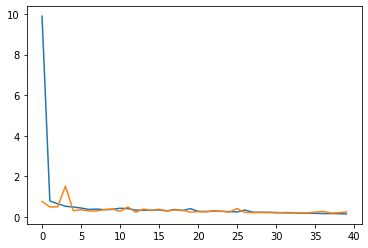

In [ ]:

plt.plot(range(0,len(history.history['mean_squared_error'])),history.history['mean_squared_error'],range(0,len(history.history['mean_squared_error'])),history.history['val_mean_squared_error'])


#### Correlation plot

0.7898793658976568


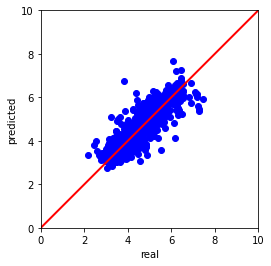

In [ ]:
from scipy import stats

x=ytest
data_pred = model.predict(xtest)
y=data_pred

from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(x,y)
print(lm.score(x,y))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x,y, color = 'blue')

plt.xlim(0, 10)
plt.ylim(0, 10)
ax.set_aspect('equal', adjustable='box')

plt.xlabel("real")
plt.ylabel("predicted")
plt.plot([0, 10], [0, 10], 'r', lw=2)


plt.show()

#### Save the model

In [ ]:
cylinders_model = model.save('Model_motor.h5')


#### Evaluate the model

In [ ]:
print('* Evaluating the performance of the trained network on the test dataset *')
print()

evaluate_model = model.evaluate(x=[xtest], y=ytest)
loss_metric = evaluate_model [0]
accuracy_metric = evaluate_model [1]

print()
print('Accuracy - ' + metrics[0] + ': %0.3f'%accuracy_metric)
print('Loss - ' + loss + ': %0.3f'%loss_metric)

* Evaluating the performance of the trained network on the test dataset *

28/28 [==============================] - 31s 1s/step - loss: 0.4445 - mean_squared_error: 0.2518

Accuracy - mean_squared_error: 0.252
Loss - mean_squared_error: 0.444
